# THE EMBER HOUSE 

Este notebook possui o intuito de fazer o estudo de aprendizado de máquina sobre os diferentes tipos de grãos de cafés disponíveis no dataset coffee-bean-dataset-resized, que possui um conjunto de 4800 imagens de 4 tipos de torras. Com o modelo obtido, será possível realizar a identificação automática de tipos de grãos de café e por qual tipo de torra aos quais foram submetidos.  

In [39]:
# carregando bibliotecas utilizadas
import kagglehub
import pandas as pd
import shutil
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


In [40]:
# Carregando dados caso ainda não importados

data_dir = "data"

if len(os.listdir(data_dir)) == 1: #Caso exista apenas o gitkeep, realiza o download do dataset
    path = kagglehub.dataset_download("gpiosenka/coffee-bean-dataset-resized-224-x-224")    
    for item in os.listdir(path):
        shutil.move(os.path.join(path, item), data_dir)
    os.rmdir(path) # Apgara o diretório de download utilizado pelo pacote kaggle       

      

In [41]:
# Load e correções em dados

coffee_info = pd.read_csv("data/Coffee Bean.csv")
coffee_info["filepaths"] = "data/"+coffee_info["filepaths"] #Ajustando o caminho das imagens conforme estrutura de diretórios criada no projeto

df_treino = coffee_info.loc[coffee_info["data set"] == "train"].copy()
df_teste = coffee_info.loc[coffee_info["data set"] == "test"].copy()


## Análise exploratória:

In [42]:
# Visualização dos dados
coffee_info.head()

,class index,filepaths,labels,data set
0,0,data/train/Dark/dark (1).png,Dark,train
1,0,data/train/Dark/dark (10).png,Dark,train
2,0,data/train/Dark/dark (100).png,Dark,train
3,0,data/train/Dark/dark (101).png,Dark,train
4,0,data/train/Dark/dark (102).png,Dark,train


In [43]:
# Verificação de duplicatas

duplicated_files = coffee_info["filepaths"].duplicated().sum()
print("Número de arquivos duplicados:", duplicated_files)

Número de arquivos duplicados: 0


In [44]:
#Comprimento médio dos nomes dos arquivos
coffee_info["filepath_length"] = coffee_info["filepaths"].apply(len)
avg_length = coffee_info["filepath_length"].mean()
print("Comprimento médio dos nomes de arquivos:", avg_length)

Comprimento médio dos nomes de arquivos: 31.21


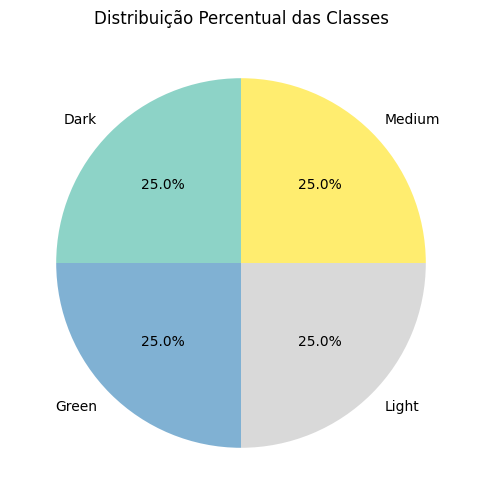

In [45]:
#Distribuição percentual das classes

plt.figure(figsize=(6,6))
coffee_info["labels"].value_counts().plot(kind="pie", autopct="%.1f%%", startangle=90, cmap="Set3")
plt.title("Distribuição Percentual das Classes")
plt.ylabel("")
plt.show()

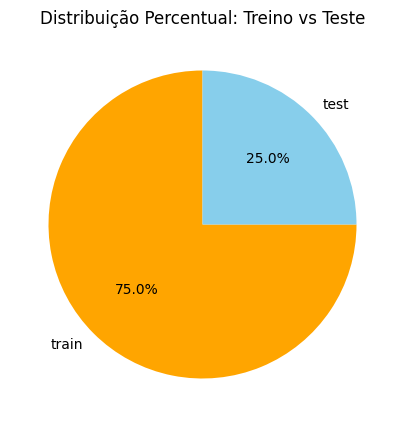

In [46]:
#Distribuição percentual do treino vs teste

plt.figure(figsize=(5,5))
coffee_info["data set"].value_counts().plot(kind="pie", autopct="%.1f%%", startangle=90, colors=["orange", "skyblue"])
plt.title("Distribuição Percentual: Treino vs Teste")
plt.ylabel("")
plt.show()

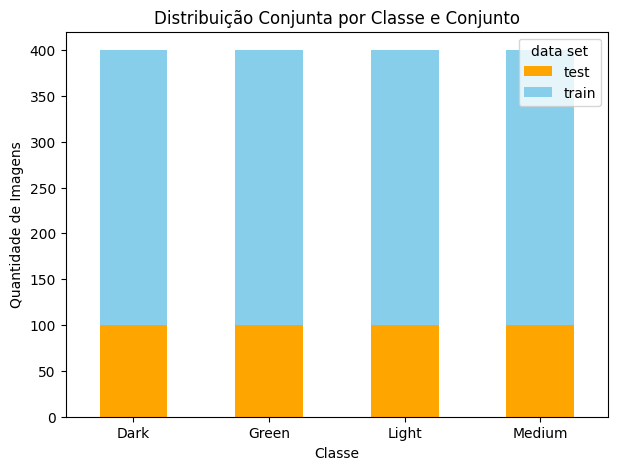

In [47]:
#Distribuição conjunta (stacked bar chart)
cross_counts = pd.crosstab(coffee_info["labels"], coffee_info["data set"])

cross_counts.plot(kind="bar", stacked=True, figsize=(7,5), color=["orange","skyblue"])
plt.title("Distribuição Conjunta por Classe e Conjunto")
plt.ylabel("Quantidade de Imagens")
plt.xlabel("Classe")
plt.xticks(rotation=0)
plt.show()

In [48]:
summary_table = coffee_info.groupby(["labels","data set"]).size().unstack(fill_value=0)
summary_table["Total"] = summary_table.sum(axis=1)
summary_table.loc["Total"] = summary_table.sum()
print(summary_table)

data set  test  train  Total
labels                      
Dark       100    300    400
Green      100    300    400
Light      100    300    400
Medium     100    300    400
Total      400   1200   1600


C:\Users\noise\AppData\Local\Temp\ipykernel_34588\810673631.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=4, random_state=6))


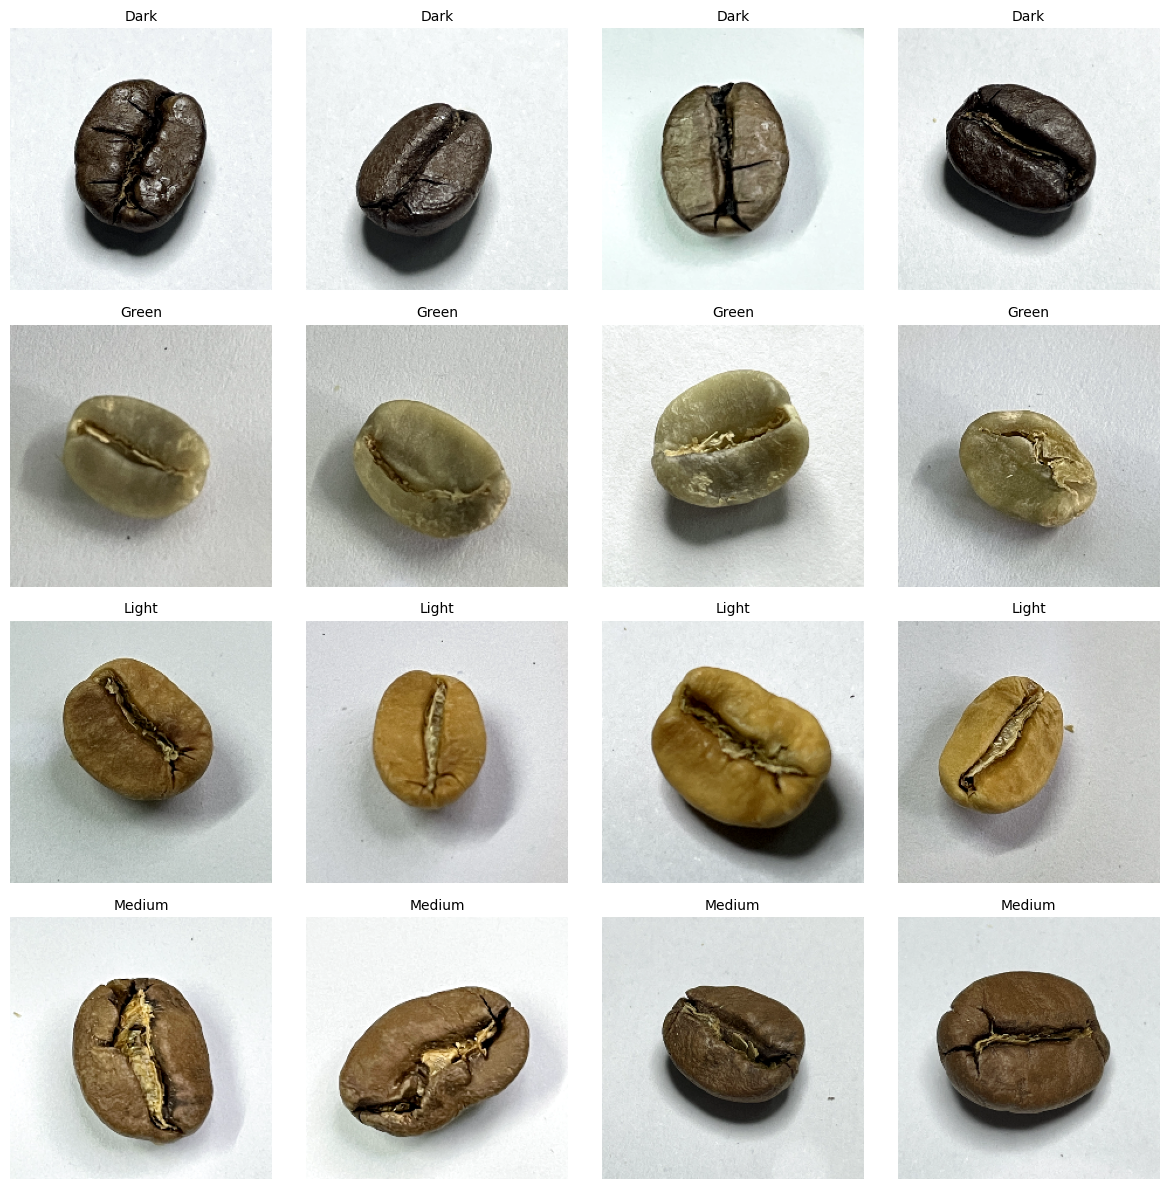

In [58]:
# Exemplos de imagens disponíveis em cada classe

amostras = (
    coffee_info.groupby("labels")
    .apply(lambda x: x.sample(n=4, random_state=6))
    .reset_index(drop=True)
)

x, axes = plt.subplots(4, 4, figsize=(12, 12))

for ax, (_, row) in zip(axes.flatten(), amostras.iterrows()):
    img = Image.open(row['filepaths'])
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(row['labels'], fontsize=10)

plt.tight_layout()
plt.show()

In [56]:
def retorna_info_arquivos(caminho):
    return os.path.getsize(caminho) / 1024  # conversão para KB

coffee_info['tamanho_kb'] = coffee_info['filepaths'].apply(retorna_info_arquivos)
tamanho_medio_arquivos = coffee_info['tamanho_kb'].mean()
maior_imagem = coffee_info["tamanho_kb"].max()
menor_imagem = coffee_info["tamanho_kb"].min()
desvio_tamanho = coffee_info["tamanho_kb"].std()

print(f'Tamanho médio dos arquivos de imagem: {round(tamanho_medio_arquivos, 2)} KB')
print(f'Menor imagem {round(menor_imagem, 2)} KB')
print(f'Maior imagem {round(maior_imagem, 2)} KB')
print(f'Desvio padrão no tamanho das imagem {round(desvio_tamanho, 2)} KB')


Tamanho médio dos arquivos de imagem: 94.68 KB
Menor imagem 77.93 KB
Maior imagem 108.02 KB
Desvio padrão no tamanho das imagem 4.55 KB


In [51]:
def retorna_dimensao_imagem(caminho):
    with Image.open(caminho) as img:
        return img.size  
    
coffee_info['dimensao'] = coffee_info['filepaths'].apply(retorna_dimensao_imagem)    

print(coffee_info['dimensao'].unique())

[(224, 224)]


In [52]:
# conta quantidades de cores para cada foto

def conta_cores(caminho):
    with Image.open(caminho) as img:
        img_array = np.array(img)
        pixels = img_array.reshape(-1, img_array.shape[-1])    
        cores_unicas = len(np.unique(pixels, axis=0))    
    return cores_unicas

coffee_info['num_cores'] = coffee_info['filepaths'].apply(conta_cores)

In [53]:
cores = coffee_info.groupby('labels')['num_cores'].agg(
    media='mean',
    maximo='max',
    minimo='min',
    desvio_padrao='std'
).reset_index()

print(cores)

   labels       media  maximo  minimo  desvio_padrao
0    Dark   7231.0650   10852    4570    1346.425399
1   Green   8048.0425   12444    4640    1398.438248
2   Light  10046.6975   15723    6195    1679.304691
3  Medium   8548.0475   13785    5560    1392.412618


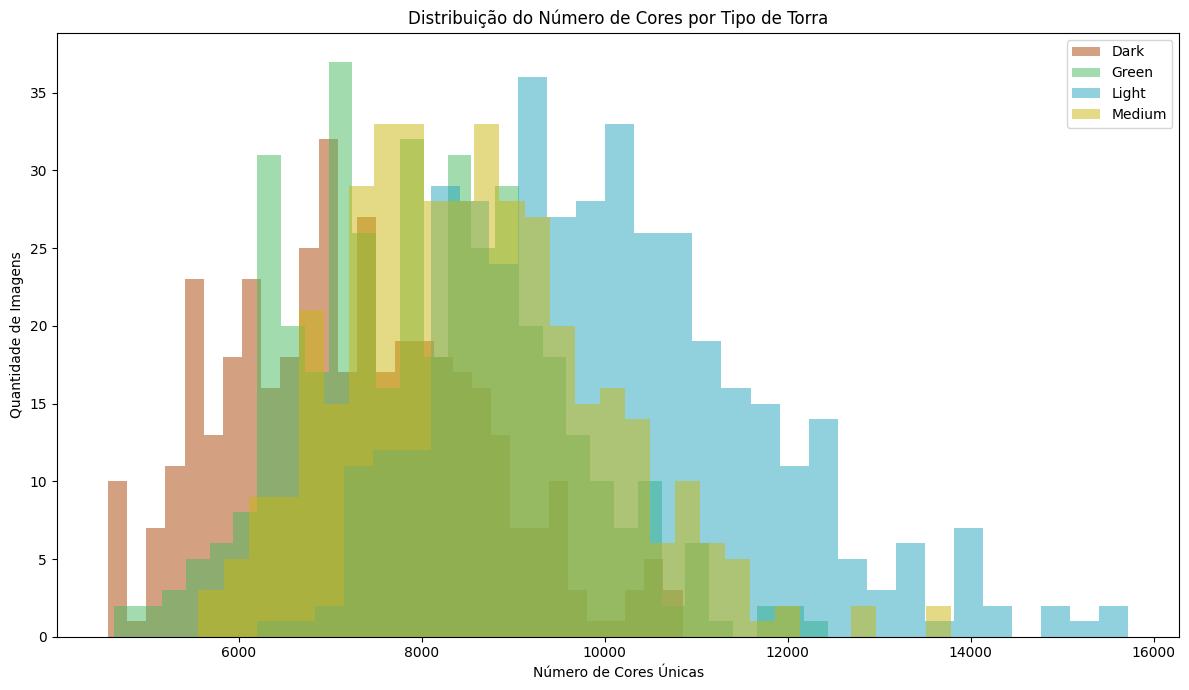

In [54]:
# Apresenta diferença na diversidade de cores em cada foto para cada tipo de torra

plt.figure(figsize=(12,7))
cores = ["#AA4307", "#47B85F", "#22A5BD", "#CAB70E"]
labels = coffee_info['labels'].unique()

for cor, label in zip(cores, labels):
    dados = coffee_info[coffee_info['labels'] == label]['num_cores']
    plt.hist(dados, bins=30, alpha=0.5, color=cor, label=label)

plt.title('Distribuição do Número de Cores por Tipo de Torra')
plt.xlabel('Número de Cores Únicas')
plt.ylabel('Quantidade de Imagens')
plt.legend()
plt.tight_layout()
plt.show()